In [1]:
import pandas as pd, numpy as np, gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
pd.set_option('display.max_columns', None)
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import MinMaxScaler
import polars as pl
import lightgbm as lgb
from scipy.stats import gmean
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
targets = pd.read_csv('/kaggle/input/performace-student-2/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [3]:
fqid =  ['archivist', 'archivist_glasses', 'block', 'block_0', 'block_1', 'block_badge', 'block_badge_2', 'block_magnify', 'block_nelson', 'block_tocollection', 'block_tomap1', 'block_tomap2', 'boss', 'businesscards', 'businesscards.card_0.next', 'businesscards.card_1.next', 'businesscards.card_bingo.bingo', 'businesscards.card_bingo.next', 'ch3start', 'chap1_finale', 'chap1_finale_c', 'chap2_finale', 'chap2_finale_c', 'chap4_finale_c', 'coffee', 'colorbook', 'confrontation', 'crane_ranger', 'cs', 'directory', 'directory.closeup.archivist', 'door_block_clean', 'door_block_talk', 'doorblock', 'expert', 'flag_girl', 'fox', 'glasses', 'gramps', 'groupconvo', 'groupconvo_flag', 'intro', 'janitor', 'journals', 'journals.hub.topics', 'journals.pic_0.next', 'journals.pic_1.next', 'journals.pic_2.bingo', 'journals.pic_2.next', 'journals_flag', 'journals_flag.hub.topics', 'journals_flag.hub.topics_old', 'journals_flag.pic_0.bingo', 'journals_flag.pic_0.next', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1.bingo', 'journals_flag.pic_1.next', 'journals_flag.pic_1_old.next', 'journals_flag.pic_2.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2_old.next', 'key', 'lockeddoor', 'logbook', 'logbook.page.bingo', 'magnify', 'need_glasses', 'notebook', 'outtolunch', 'photo', 'plaque', 'plaque.face.date', 'reader', 'reader.paper0.next', 'reader.paper0.prev', 'reader.paper1.next', 'reader.paper1.prev', 'reader.paper2.bingo', 'reader.paper2.next', 'reader.paper2.prev', 'reader_flag', 'reader_flag.paper0.next', 'reader_flag.paper0.prev', 'reader_flag.paper1.next', 'reader_flag.paper1.prev', 'reader_flag.paper2.bingo', 'reader_flag.paper2.next', 'reader_flag.paper2.prev', 'remove_cup', 'report', 'retirement_letter', 'savedteddy', 'seescratches', 'teddy', 'tobasement', 'tocage', 'tocloset', 'tocloset_dirty', 'tocollection', 'tocollectionflag', 'toentry', 'tofrontdesk', 'togrampa', 'tohallway', 'tomap', 'tomicrofiche', 'tostacks', 'tracks', 'tracks.hub.deer', 'trigger_coffee', 'trigger_scarf', 'tunic', 'tunic.capitol_0', 'tunic.capitol_1', 'tunic.capitol_2', 'tunic.drycleaner', 'tunic.flaghouse', 'tunic.historicalsociety', 'tunic.hub.slip', 'tunic.humanecology', 'tunic.kohlcenter', 'tunic.library', 'tunic.wildlife', 'unlockdoor', 'wells', 'wellsbadge', 'what_happened', 'worker']
room =  ['tunic.capitol_0.hall', 'tunic.capitol_1.hall', 'tunic.capitol_2.hall', 'tunic.drycleaner.frontdesk', 'tunic.flaghouse.entry', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.cage', 'tunic.historicalsociety.closet', 'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.collection_flag', 'tunic.historicalsociety.entry', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.humanecology.frontdesk', 'tunic.kohlcenter.halloffame', 'tunic.library.frontdesk', 'tunic.library.microfiche', 'tunic.wildlife.center']
name =  ['basic', 'undefined', 'close', 'open', 'prev', 'next']
EVENTS =  ['navigate_click', 'person_click', 'cutscene_click', 'object_click', 'map_hover', 'notification_click', 'map_click', 'observation_click', 'checkpoint']
CATS =  ['event_name', 'fqid', 'room_fqid', 'text']
NUMS =  ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'index', 'screen_coor_x', 'screen_coor_y']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

In [4]:
print('Read: ')
print('df1.. /' ,end='')
df1 = pd.read_csv('/kaggle/input/performance-notebook/df1.csv')
print(' df2.. /' ,end='')
df2 = pd.read_csv('/kaggle/input/performance-notebook/df2.csv')
print(' df3.. |')
df3 = pd.read_csv('/kaggle/input/performance-notebook/df3.csv')

print('\nData Shape:')
# print(f'train shape {train.shape}')
print(f'df1 {df1.shape} , df2 {df2.shape} , df3 {df3.shape}')

Read: 
df1.. / df2.. / df3.. |

Data Shape:
df1 (23562, 722) , df2 (23562, 1096) , df3 (23562, 1297)


In [5]:
# print('Concat DataFrame')
# print('df1 concatination with df .. ')
# df1 = df1.join(df, on='session_id',how='left')
# print(f'df1 concatination with df || df1 shape {df1.shape}')
# df2 = df2.join(df, on='session_id',how='left')
# print(f'df2 concatination with df || df2 shape {df2.shape}')
# df3 = df3.join(df, on='session_id',how='left')
# print(f'df3 concatination with df || df2 shape {df3.shape}')

In [6]:
def duplicated_feature(df):
    print('delete dupilcate columns..')
    df_temp = df.copy()
    columns_dataFrame = df.columns
    df = df.T.drop_duplicates().T
    columns_df_temp = df.columns
    final_columns_with_no_duplicate = [col for col in columns_dataFrame if col not in columns_df_temp]
    df = df_temp.copy()
    df = df.drop(final_columns_with_no_duplicate,axis=1)
    print('delet unique and null with 90%')
    null1 = df.isnull().sum().sort_values(ascending=False)/len(df)
    drop1 = list(null1[null1 > 0.9].index)
    for col in df.columns:
        if df[col].nunique() == 1:
            drop1.append(col)
    df = df.drop(drop1,axis=1)
    print(f'{len(final_columns_with_no_duplicate)} features removed!')
    del df_temp,  columns_dataFrame, columns_df_temp, final_columns_with_no_duplicate, null1, drop1
    gc.collect()
    print()
    return df

In [7]:
print('Duplicated Feature in DataFrame : \n')
# print(f'from shape {df1.shape} ')
df1 = duplicated_feature(df1)
print(f'The DataFrame1 Now has || {df1.shape}')
# print(f'from shape {df2.shape} ')
df2 = duplicated_feature(df2)
print(f'The DataFrame2 Now has || {df2.shape}')
# print(f'from shape {df3.shape} ')
df3 = duplicated_feature(df3)
print(f'The DataFrame3 Now has || {df3.shape}')

Duplicated Feature in DataFrame : 

delete dupilcate columns..
delet unique and null with 90%
108 features removed!

The DataFrame1 Now has || (23562, 614)
delete dupilcate columns..
delet unique and null with 90%
123 features removed!

The DataFrame2 Now has || (23562, 973)
delete dupilcate columns..
delet unique and null with 90%
163 features removed!

The DataFrame3 Now has || (23562, 1134)


In [8]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [9]:
FEATURES1 = [c for c in df1.columns if c != 'level_group']
print('We will train df1 with', len(FEATURES1) ,'features')
FEATURES2 = [c for c in df2.columns if c != 'level_group']
print('We will train df2 with', len(FEATURES2) ,'features')
FEATURES3 = [c for c in df3.columns if c != 'level_group']
print('We will train df3 with', len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train df1 with 613 features
We will train df2 with 972 features
We will train df3 with 1133 features
We will train with 23562 users info


In [10]:
%%time
print('###################### CatBoost Model ###########################')
gkf = GroupKFold(n_splits=5)
oof_cbt = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
models = {}

for t in range(1,19):
    print('# Question:',t)
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3:
        grp = '0-4'
        FEATURES = FEATURES1
        df = df1
    elif t<=13: 
        grp = '5-12'
        FEATURES = FEATURES2
        df = df2
    elif t<=22: 
        grp = '13-22'
        FEATURES = FEATURES3
        df = df3

    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):

        print(f'Fold{i+1}',end='')
           
        cat_params = {
        'loss_function' : 'Logloss',
        'eval_metric' : 'Logloss',
        'learning_rate': 0.05,
        'max_depth': 4,
        'num_boost_round': 1000,
        'od_type' : 'Iter',
        'od_wait': 50,
        }
        
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

             # TRAIN MODEL
        train_pool = Pool(train_x[FEATURES],
                          train_y['correct'])  
        test_pool = Pool(valid_x[FEATURES],
                         valid_y['correct'])
        clf =  CatBoostClassifier(**cat_params)
        clf.fit(train_pool, eval_set=[test_pool],verbose=0)
        print(f' ({clf.best_iteration_}),  ',end='')
        cbt_predtict = clf.predict_proba(valid_x[FEATURES])[:,1]
        # SAVE MODEL, PREDICT VALID OOF
        clf.save_model(f'{i+1}_{grp}_{t}.cbm')
        # oof predict
        oof_cbt.loc[valid_users, f'meta_{t}'] = cbt_predtict
        
    print('\n')

###################### CatBoost Model ###########################
# Question: 1
Fold1 (328),  Fold2 (379),  Fold3 (483),  Fold4 (299),  Fold5 (550),  

# Question: 2
Fold1 (293),  Fold2 (199),  Fold3 (197),  Fold4 (195),  Fold5 (222),  

# Question: 3
Fold1 (267),  Fold2 (436),  Fold3 (520),  Fold4 (241),  Fold5 (407),  

# Question: 4
Fold1 (263),  Fold2 (257),  Fold3 (358),  Fold4 (324),  Fold5 (254),  

# Question: 5
Fold1 (276),  Fold2 (346),  Fold3 (280),  Fold4 (387),  Fold5 (403),  

# Question: 6
Fold1 (286),  Fold2 (378),  Fold3 (317),  Fold4 (380),  Fold5 (322),  

# Question: 7
Fold1 (385),  Fold2 (261),  Fold3 (407),  Fold4 (463),  Fold5 (284),  

# Question: 8
Fold1 (145),  Fold2 (160),  Fold3 (136),  Fold4 (198),  Fold5 (207),  

# Question: 9
Fold1 (457),  Fold2 (373),  Fold3 (308),  Fold4 (273),  Fold5 (319),  

# Question: 10
Fold1 (305),  Fold2 (191),  Fold3 (329),  Fold4 (523),  Fold5 (435),  

# Question: 11
Fold1 (246),  Fold2 (199),  Fold3 (280),  Fold4 (251),  Fo

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

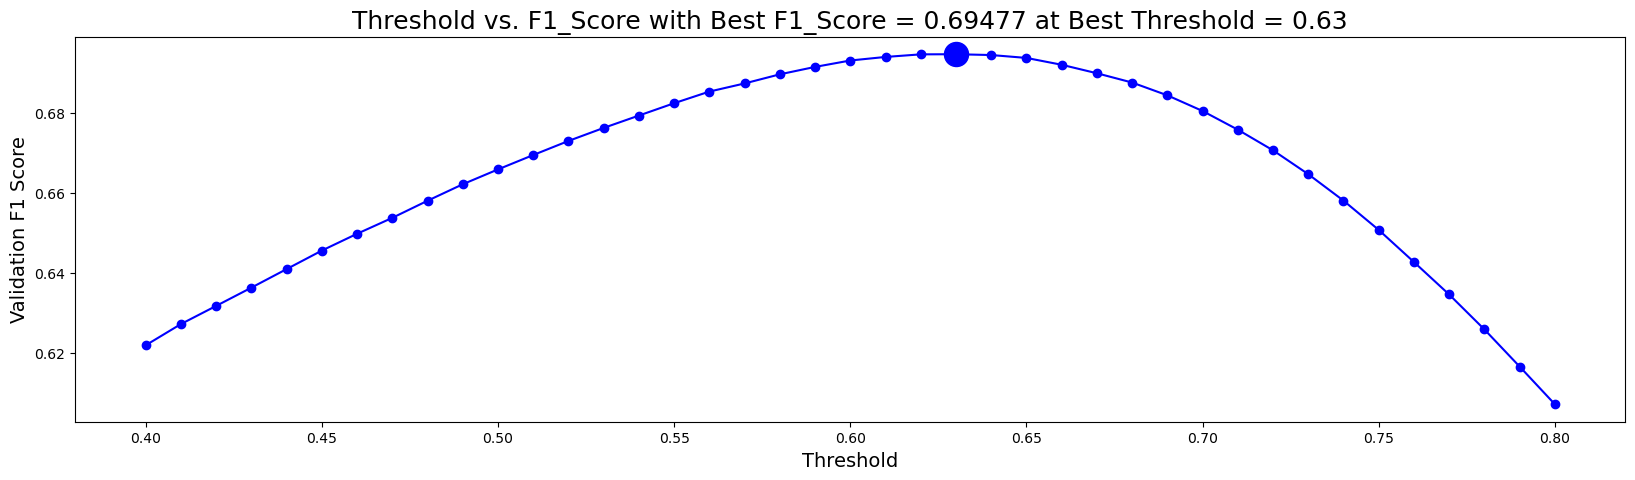

In [11]:
true = oof_cbt.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof_cbt.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [12]:
print(f'\nThreshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}')


Threshold vs. F1_Score with Best F1_Score = 0.69477 at Best Threshold = 0.63


In [13]:
%%time
print('###################### LGBM Model ###########################')
gkf = GroupKFold(n_splits=5)
oof_lgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
models = {}

for t in range(1,19):
    print('# Question:',t)
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3:
        grp = '0-4'
        FEATURES = FEATURES1
        df = df1
    elif t<=13: 
        grp = '5-12'
        FEATURES = FEATURES2
        df = df2
    elif t<=22: 
        grp = '13-22'
        FEATURES = FEATURES3
        df = df3

    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):

        print(f'Fold{i+1}',end='')
        
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        
        # TRAIN MODEL
        params = {'objective':'binary', 'metric':'binary_logloss',#'device':'gpu',
                  'learning_rate': 0.05,'max_depth':4, 'subsample':0.8, 'colsample_bytree': 0.4,#'feature_fraction':0.4,
                   'random_state':42,
                  'verbose':-1}
        callbacks = [lgb.early_stopping(20, verbose=False), lgb.log_evaluation(period=0)]
         
        lgb_train = lgb.Dataset(train_x[FEATURES].astype('float32'), train_y['correct'].values)
        lgb_eval = lgb.Dataset(valid_x[FEATURES].astype('float32'), valid_y['correct'].values)
        clf = lgb.train(params, train_set=lgb_train, valid_sets=[lgb_eval],callbacks=callbacks,num_boost_round=3000)         
        
        
        print(f' ({clf.best_iteration}), ',end='')
        lgb_predict = clf.predict(valid_x[FEATURES].astype('float32'))
        # SAVE MODEL
        models[f'{i+1}_{grp}_{t}.xgb'] = clf
        clf.save_model(f'{i+1}_{grp}_{t}.lgb')

        oof_lgb.loc[valid_users, f'meta_{t}'] = lgb_predict

    print('\n')

###################### LGBM Model ###########################
# Question: 1
Fold1 (171), Fold2 (169), Fold3 (118), Fold4 (143), Fold5 (182), 

# Question: 2
Fold1 (48), Fold2 (78), Fold3 (56), Fold4 (97), Fold5 (69), 

# Question: 3
Fold1 (86), Fold2 (137), Fold3 (100), Fold4 (74), Fold5 (120), 

# Question: 4
Fold1 (164), Fold2 (136), Fold3 (90), Fold4 (144), Fold5 (157), 

# Question: 5
Fold1 (208), Fold2 (119), Fold3 (177), Fold4 (161), Fold5 (191), 

# Question: 6
Fold1 (150), Fold2 (173), Fold3 (152), Fold4 (222), Fold5 (167), 

# Question: 7
Fold1 (149), Fold2 (167), Fold3 (190), Fold4 (135), Fold5 (190), 

# Question: 8
Fold1 (90), Fold2 (77), Fold3 (93), Fold4 (103), Fold5 (100), 

# Question: 9
Fold1 (137), Fold2 (143), Fold3 (146), Fold4 (137), Fold5 (144), 

# Question: 10
Fold1 (107), Fold2 (186), Fold3 (99), Fold4 (135), Fold5 (159), 

# Question: 11
Fold1 (127), Fold2 (133), Fold3 (101), Fold4 (140), Fold5 (162), 

# Question: 12
Fold1 (111), Fold2 (109), Fold3 (44), Fold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

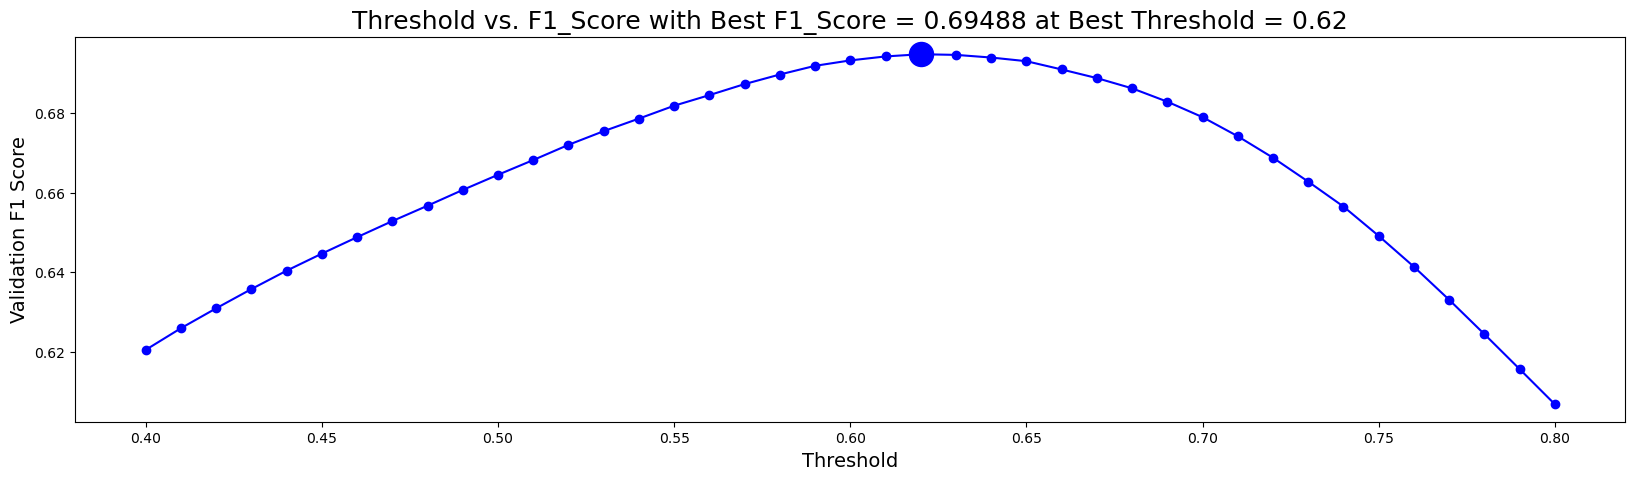

In [14]:
true = oof_lgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof_lgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

In [15]:
print(f'\nThreshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}')


Threshold vs. F1_Score with Best F1_Score = 0.69488 at Best Threshold = 0.62


In [16]:
%%time
print('###################### XGBoost Model ###########################')
gkf = GroupKFold(n_splits=5)
# oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
models = {}
for t in range(1,19):
    print('# Question:',t)
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3:
        grp = '0-4'
        FEATURES = FEATURES1
        df = df1
    elif t<=13: 
        grp = '5-12'
        FEATURES = FEATURES2
        df = df2
    elif t<=22: 
        grp = '13-22'
        FEATURES = FEATURES3
        df = df3

    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):

        print(f'Fold{i+1}',end='')

        xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.05,
        'max_depth': 4,
        'n_estimators': 10000,
        'early_stopping_rounds': 20,
#         'tree_method':'gpu_hist',

        'subsample':0.8,
        'colsample_bytree': 0.4,
        'use_label_encoder' : False}

        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f' ({clf.best_ntree_limit}), ',end='')
        xgb_predict = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        # SAVE MODEL
        models[f'{i+1}_{grp}_{t}.xgb'] = clf
        clf.save_model(f'{i+1}_{grp}_{t}.xgb')
        oof_xgb.loc[valid_users, f'meta_{t}'] = xgb_predict

    print('\n')

###################### XGBoost Model ###########################
# Question: 1
Fold1 (181), Fold2 (165), Fold3 (198), Fold4 (134), Fold5 (204), 

# Question: 2
Fold1 (111), Fold2 (111), Fold3 (156), Fold4 (137), Fold5 (139), 

# Question: 3
Fold1 (136), Fold2 (140), Fold3 (168), Fold4 (147), Fold5 (155), 

# Question: 4
Fold1 (141), Fold2 (143), Fold3 (144), Fold4 (147), Fold5 (154), 

# Question: 5
Fold1 (177), Fold2 (200), Fold3 (177), Fold4 (211), Fold5 (124), 

# Question: 6
Fold1 (207), Fold2 (210), Fold3 (163), Fold4 (183), Fold5 (176), 

# Question: 7
Fold1 (141), Fold2 (138), Fold3 (138), Fold4 (161), Fold5 (178), 

# Question: 8
Fold1 (79), Fold2 (69), Fold3 (77), Fold4 (81), Fold5 (117), 

# Question: 9
Fold1 (139), Fold2 (96), Fold3 (172), Fold4 (169), Fold5 (109), 

# Question: 10
Fold1 (156), Fold2 (171), Fold3 (138), Fold4 (126), Fold5 (130), 

# Question: 11
Fold1 (99), Fold2 (90), Fold3 (105), Fold4 (123), Fold5 (141), 

# Question: 12
Fold1 (111), Fold2 (137), Fold3 (9

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

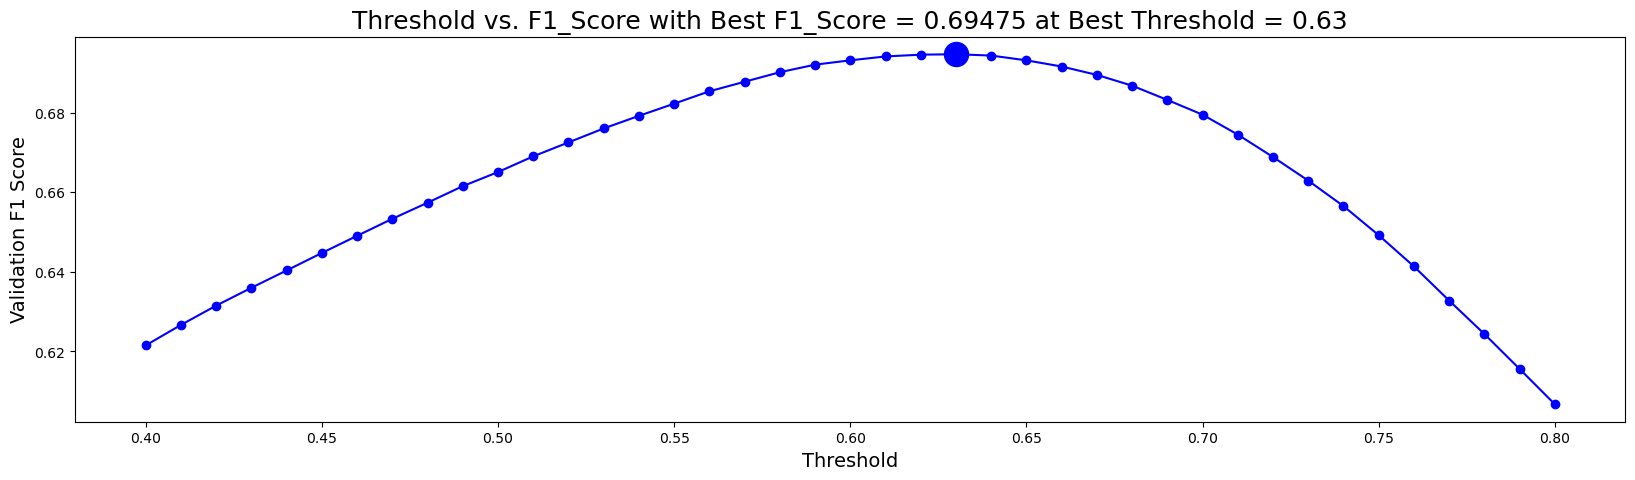

In [17]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

In [18]:
print(f'\nThreshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}')


Threshold vs. F1_Score with Best F1_Score = 0.69475 at Best Threshold = 0.63


Ensambe xgb and catboost 0.5
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

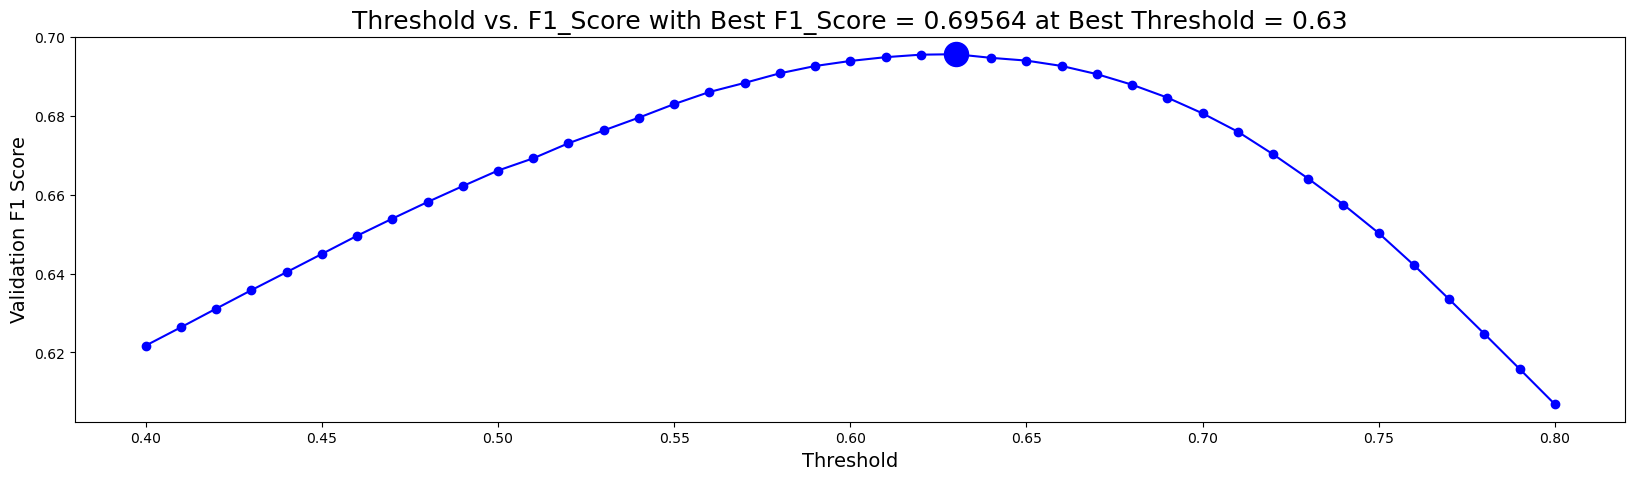

In [19]:
print('Ensambe xgb and catboost 0.5')
oof = oof_cbt*0.5 + oof_xgb*0.5
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe xgb and catboost 0.8 0.2
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

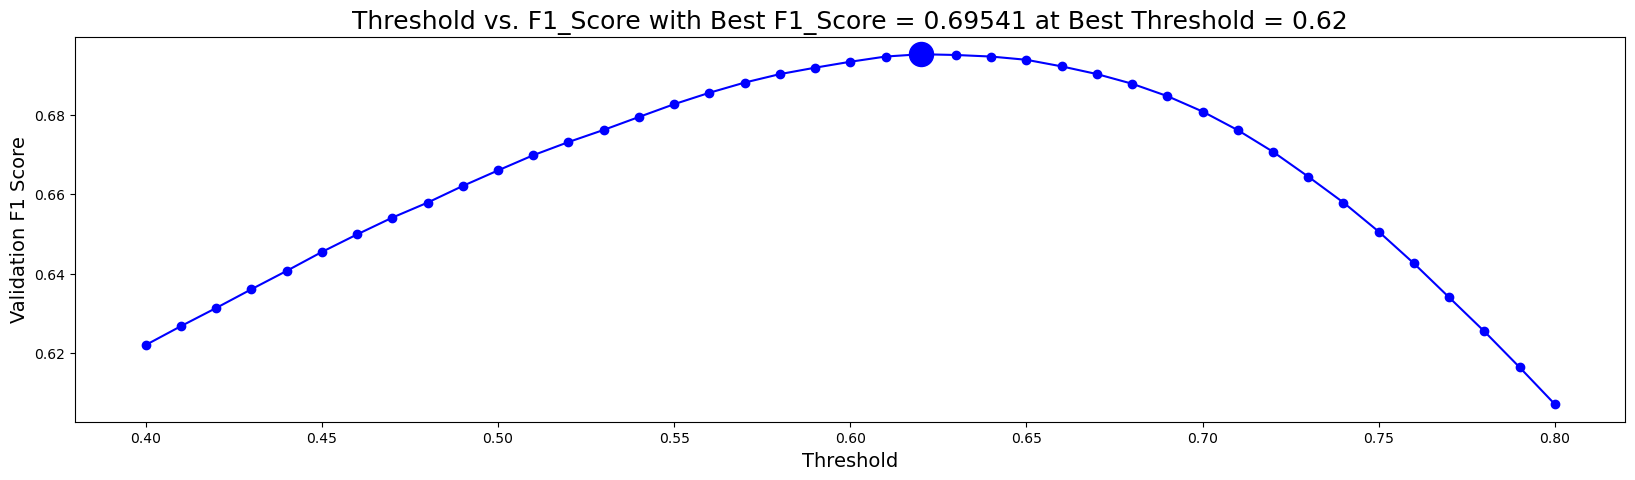

In [20]:
print('Ensambe xgb and catboost 0.8 0.2')
oof = oof_cbt*0.8 + oof_xgb*0.2
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe xgb and catboost 0.3 0.7
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

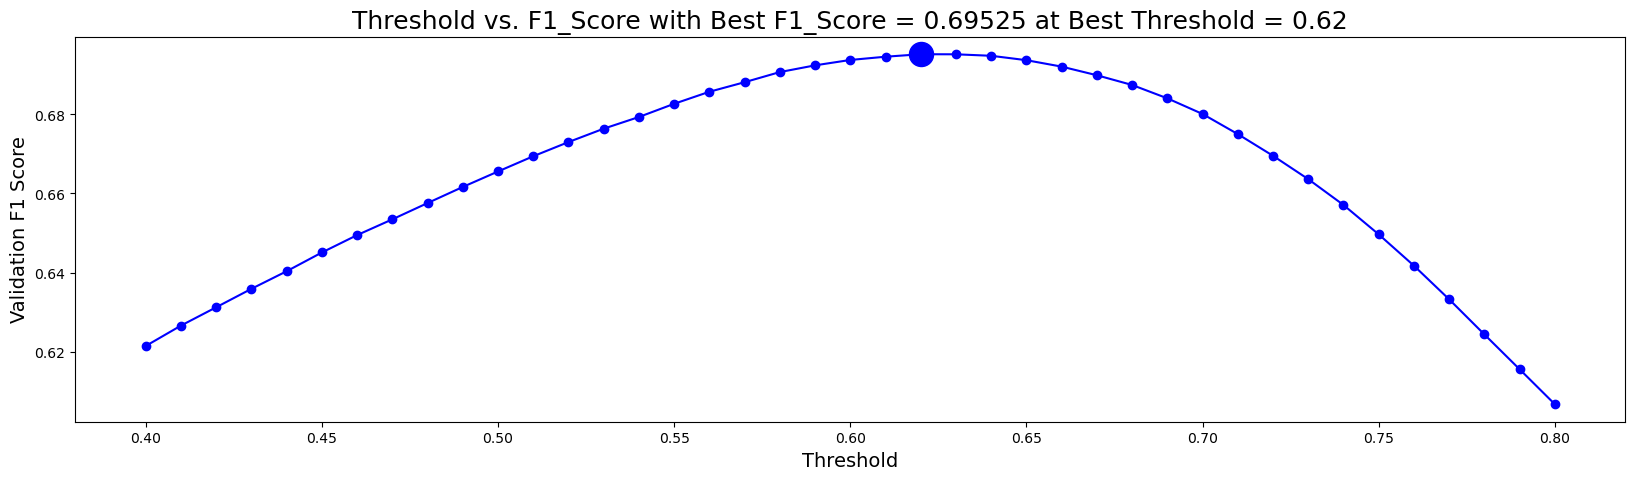

In [21]:
print('Ensambe xgb and catboost 0.3 0.7')
oof = oof_cbt*0.2 + oof_xgb*0.8
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe xgb and catboost 0.4 0.6
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

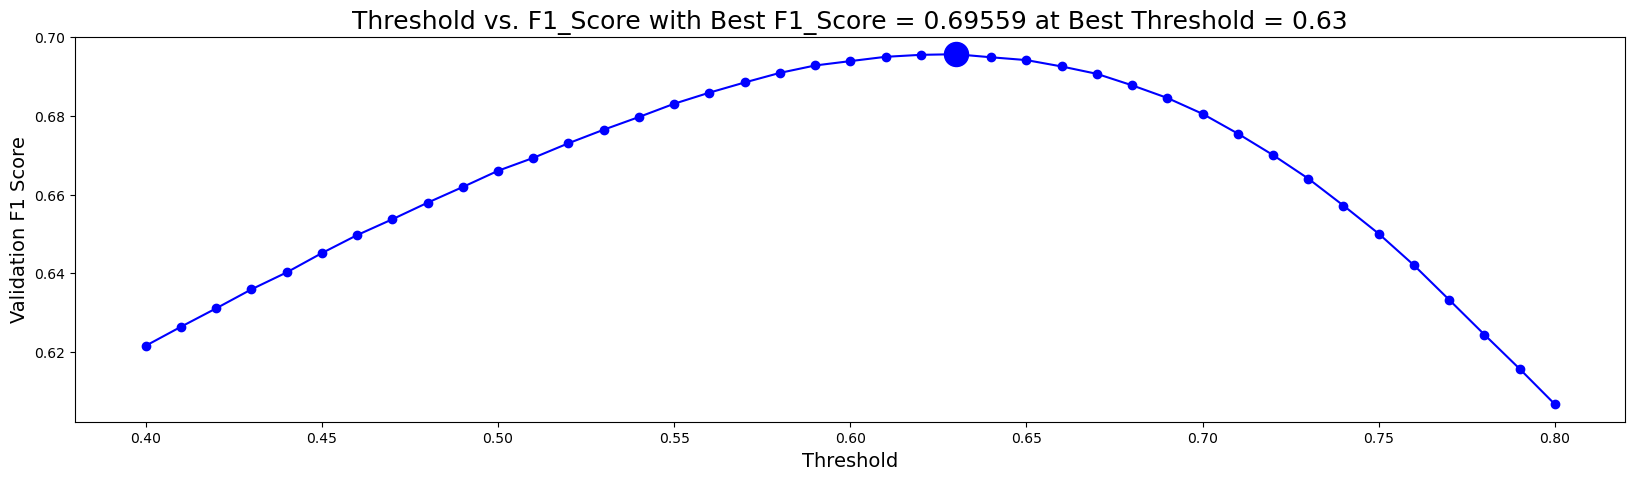

In [22]:
print('Ensambe xgb and catboost 0.4 0.6')
oof = oof_cbt*0.4 + oof_xgb*0.6
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe xgb and catboost 6 4
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

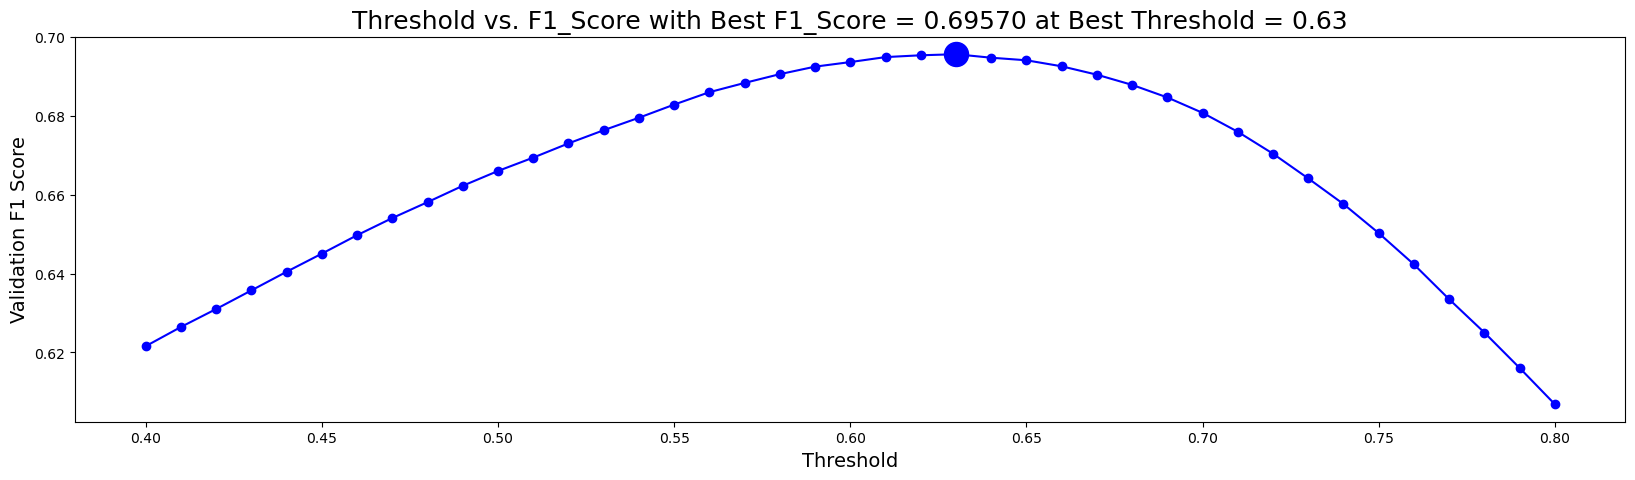

In [23]:
print('Ensambe xgb and catboost 6 4')
oof = oof_cbt*0.6 + oof_xgb*0.4
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

In [24]:
print('----------------------------------------------')

----------------------------------------------


Ensambe lgb  catboost 5 5
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

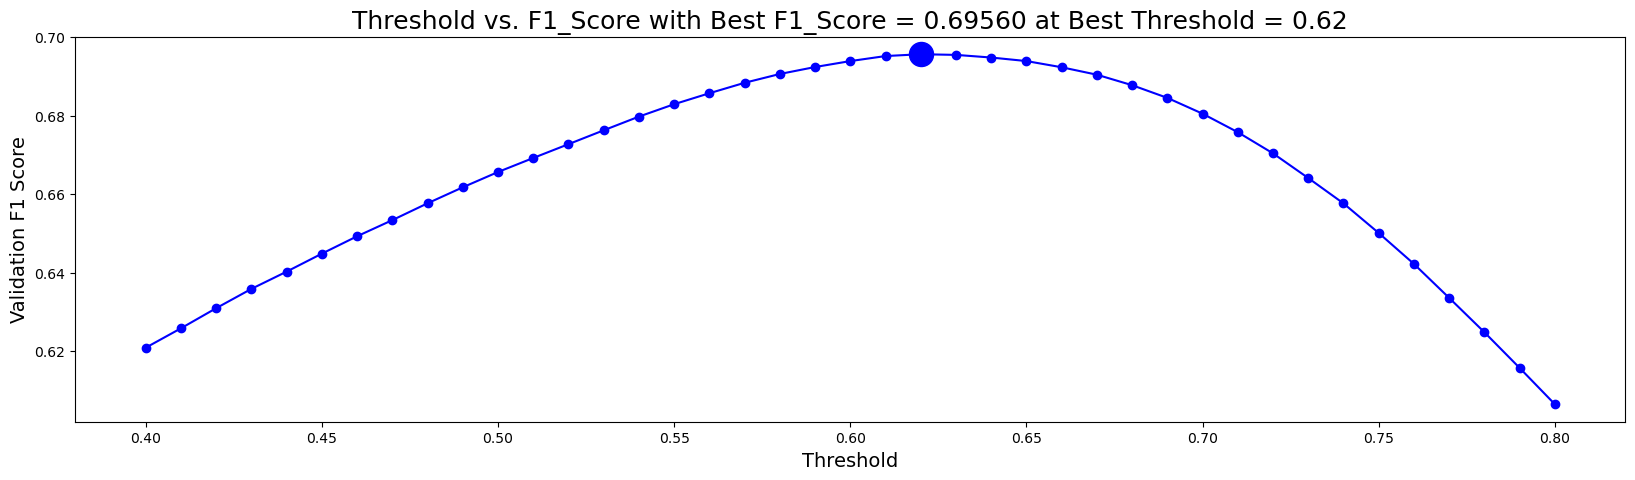

In [25]:
print('Ensambe lgb  catboost 5 5')
oof = oof_lgb*0.5 + oof_cbt*0.5
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb  catboost 2 8
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

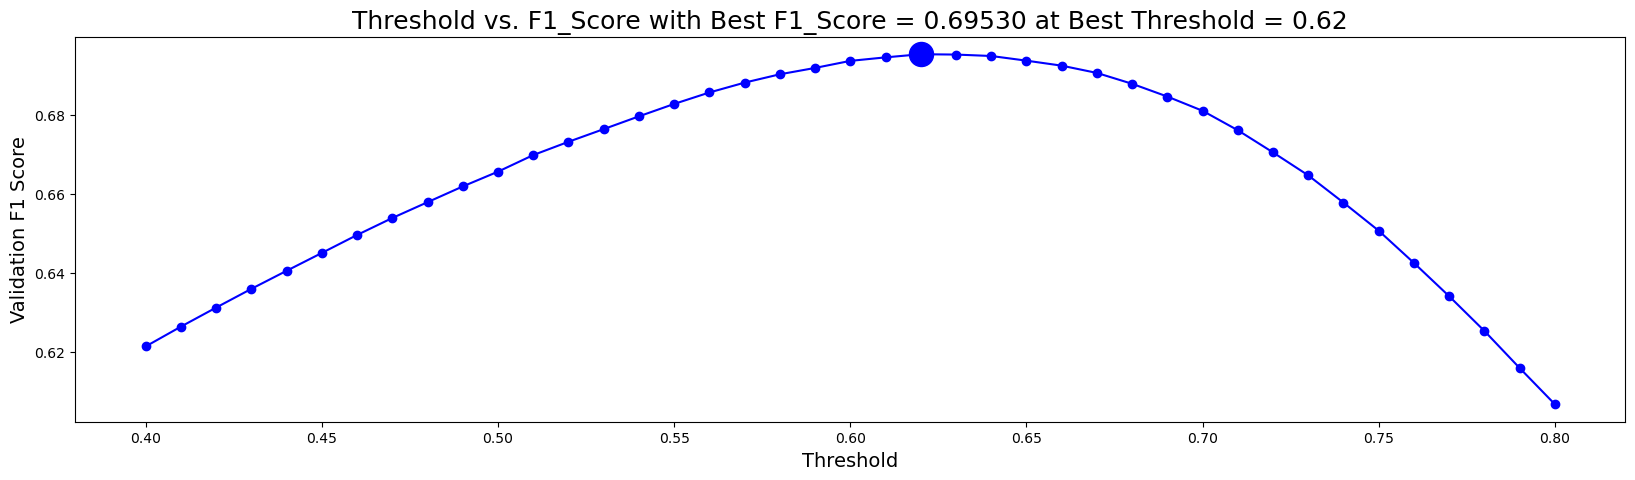

In [26]:
print('Ensambe lgb  catboost 2 8')
oof = oof_lgb*0.2 + oof_cbt*0.8
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb  catboost 0.8 0.2
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

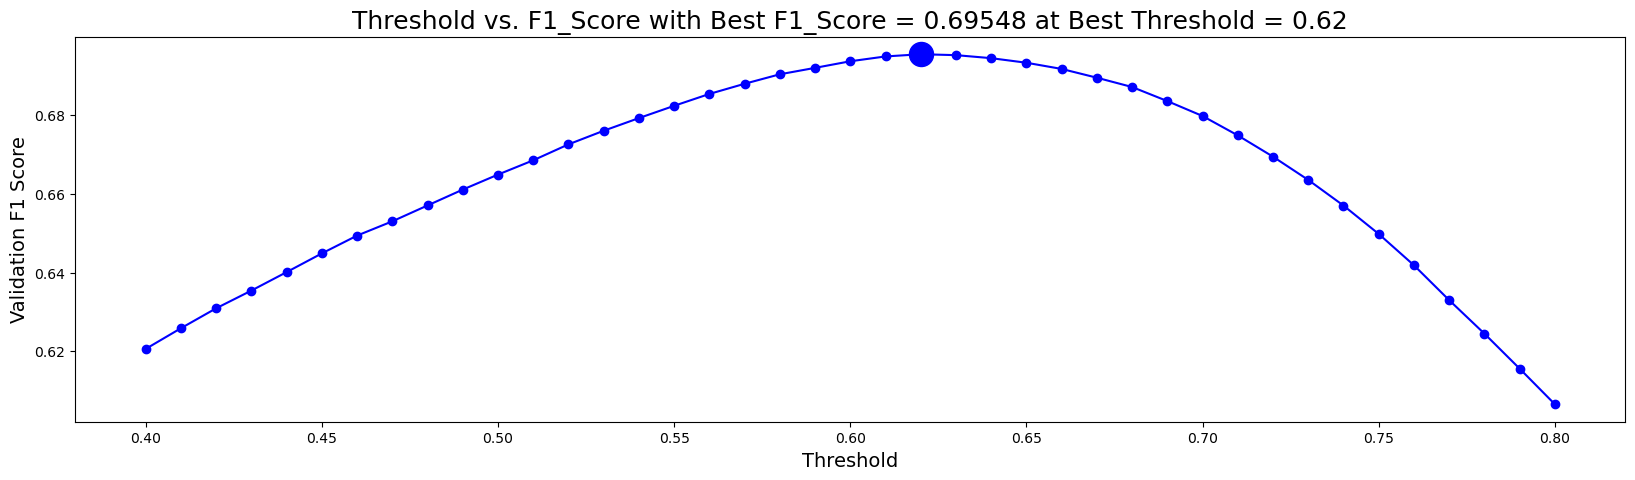

In [27]:
print('Ensambe lgb  catboost 0.8 0.2')
oof = oof_lgb*0.8 + oof_cbt*0.2
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb  catboost 4 6
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

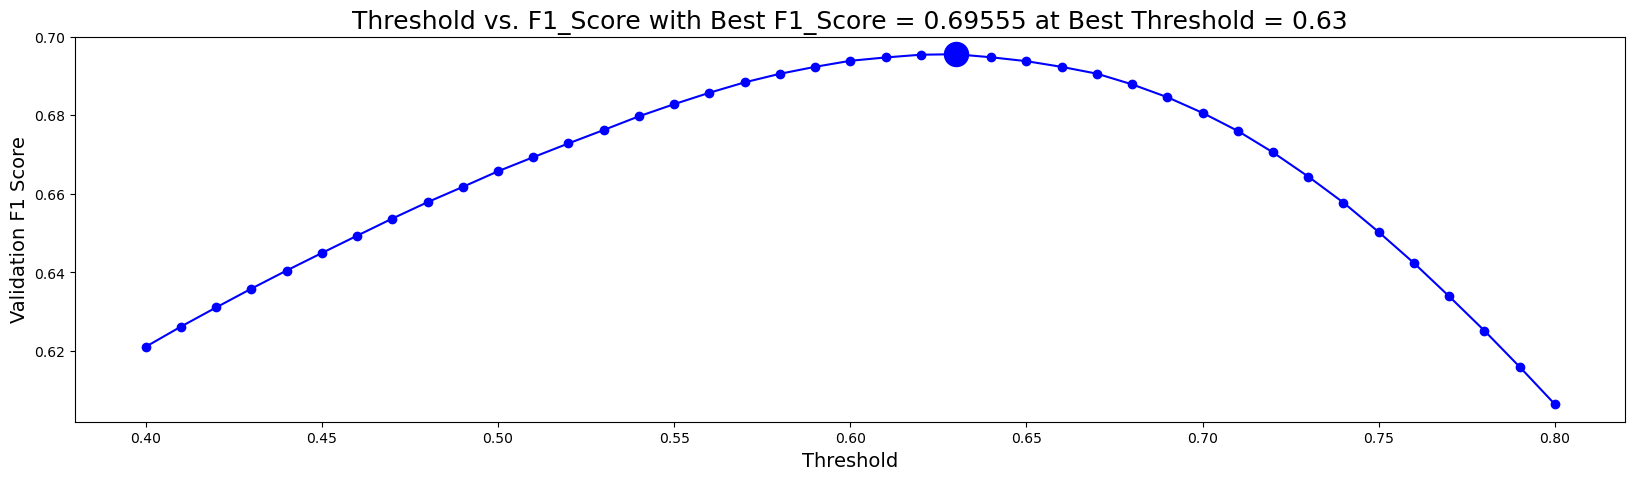

In [28]:
print('Ensambe lgb  catboost 4 6')
oof = oof_lgb*0.4 + oof_cbt*0.6
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb  catboost 6 4
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

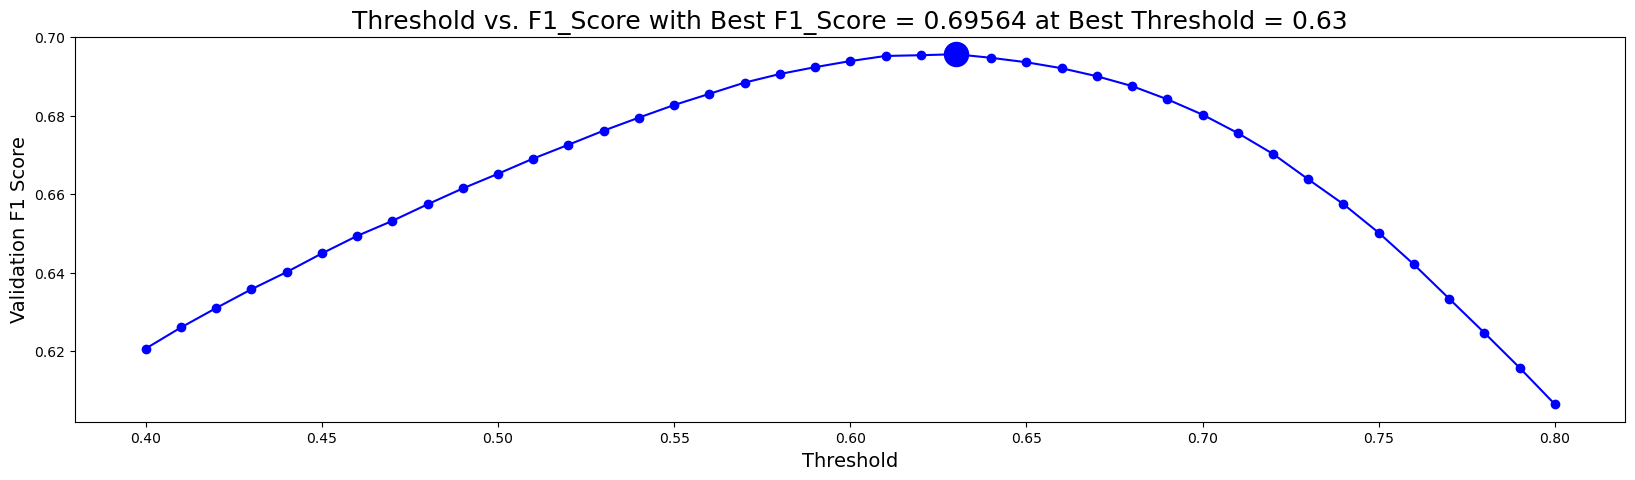

In [29]:
print('Ensambe lgb  catboost 6 4')
oof = oof_lgb*0.6 + oof_cbt*0.4
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

In [30]:
print('-------------------------------------------------------')

-------------------------------------------------------


Ensambe lgb xgb catboost 3 3 4
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

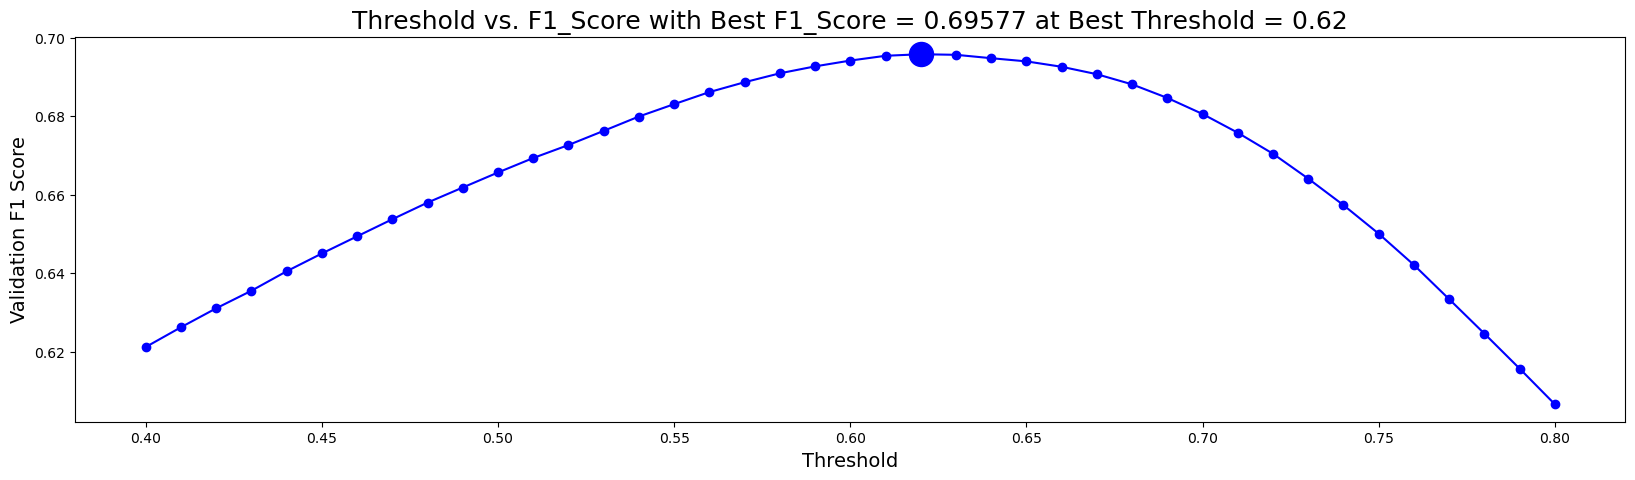

In [31]:
print('Ensambe lgb xgb catboost 3 3 4')
oof = oof_lgb*0.3 +  oof_xgb*0.3 + oof_cbt*0.4
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 3 4 3
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

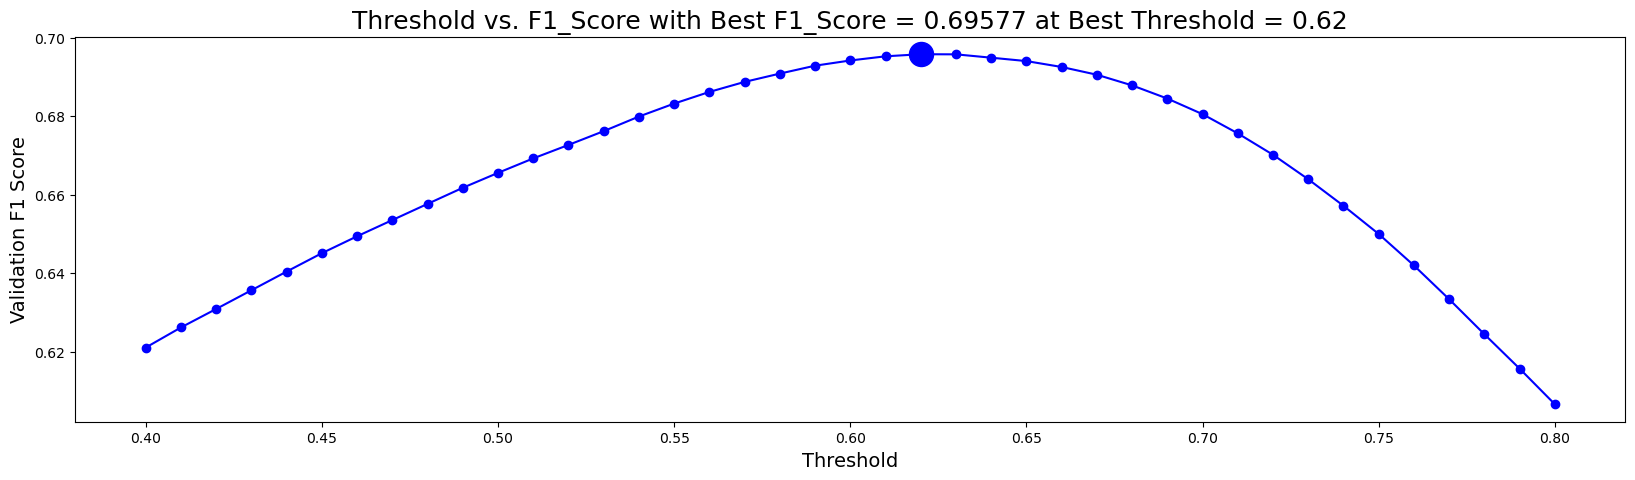

In [32]:
print('Ensambe lgb xgb catboost 3 4 3')
oof = oof_lgb*0.3 +  oof_xgb*0.4 + oof_cbt*0.3
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 4 3 3
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

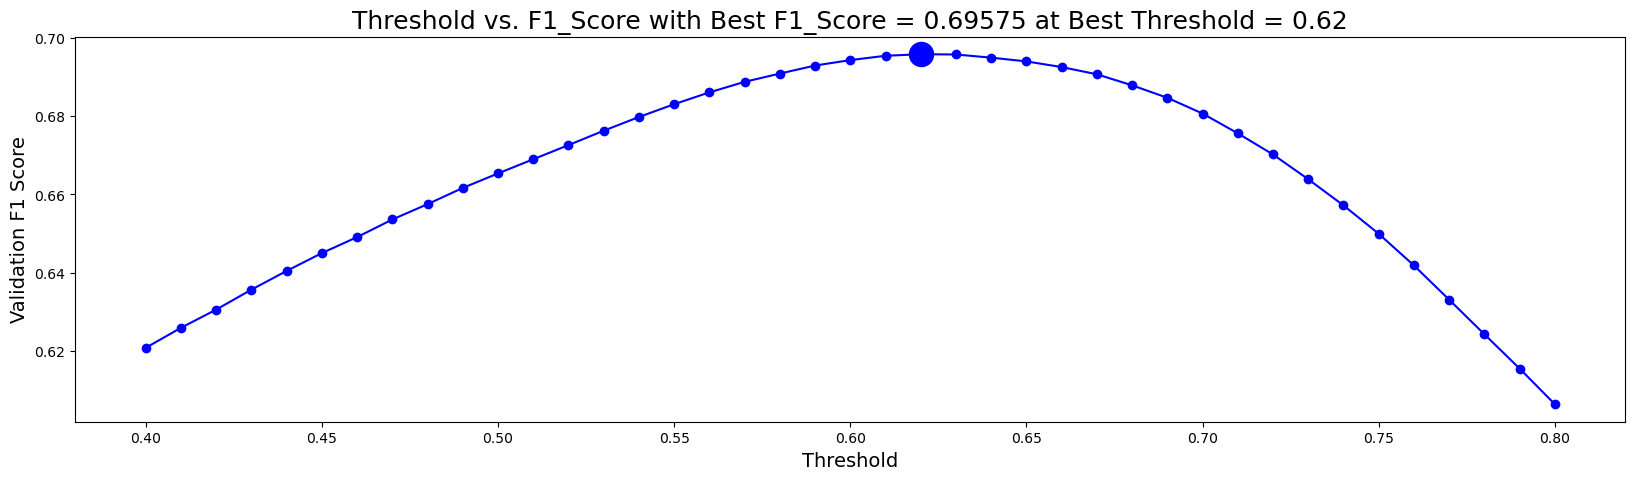

In [33]:
print('Ensambe lgb xgb catboost 4 3 3')
oof = oof_lgb*0.4 +  oof_xgb*0.3 + oof_cbt*0.3
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 2 3 5
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

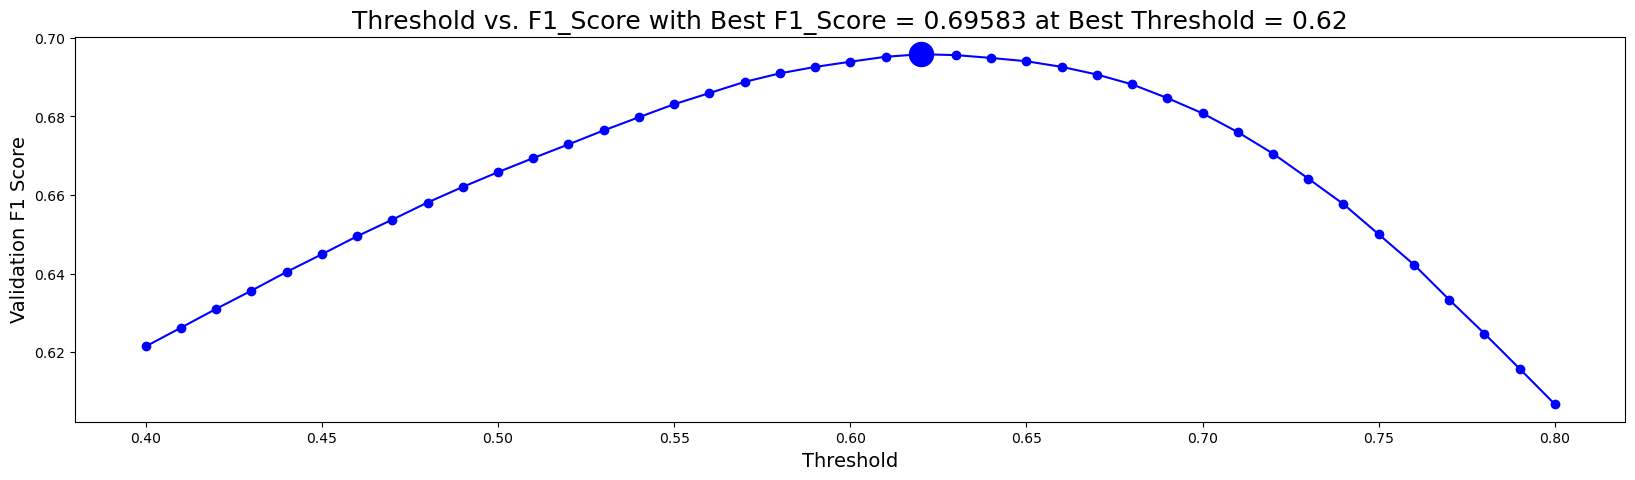

In [34]:
print('Ensambe lgb xgb catboost 2 3 5')
oof = oof_lgb*0.2 +  oof_xgb*0.3 + oof_cbt*0.5
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 1 4 5
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

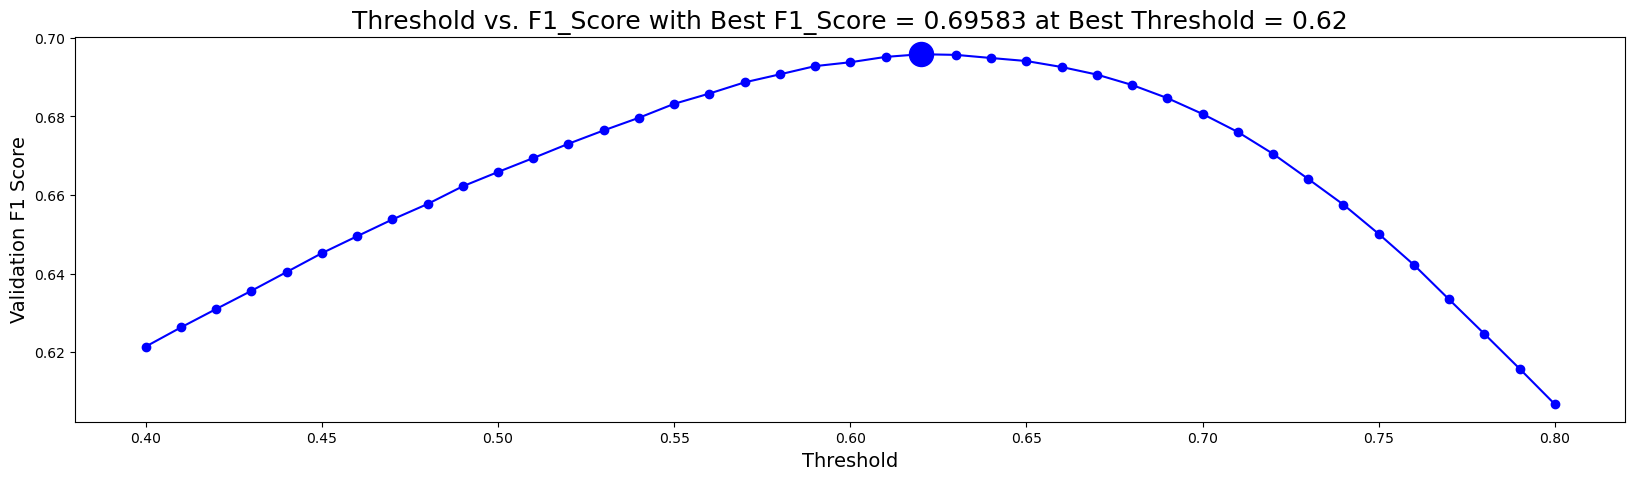

In [35]:
print('Ensambe lgb xgb catboost 1 4 5')
oof = oof_lgb*0.1 +  oof_xgb*0.4 + oof_cbt*0.5
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 1 3 6
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

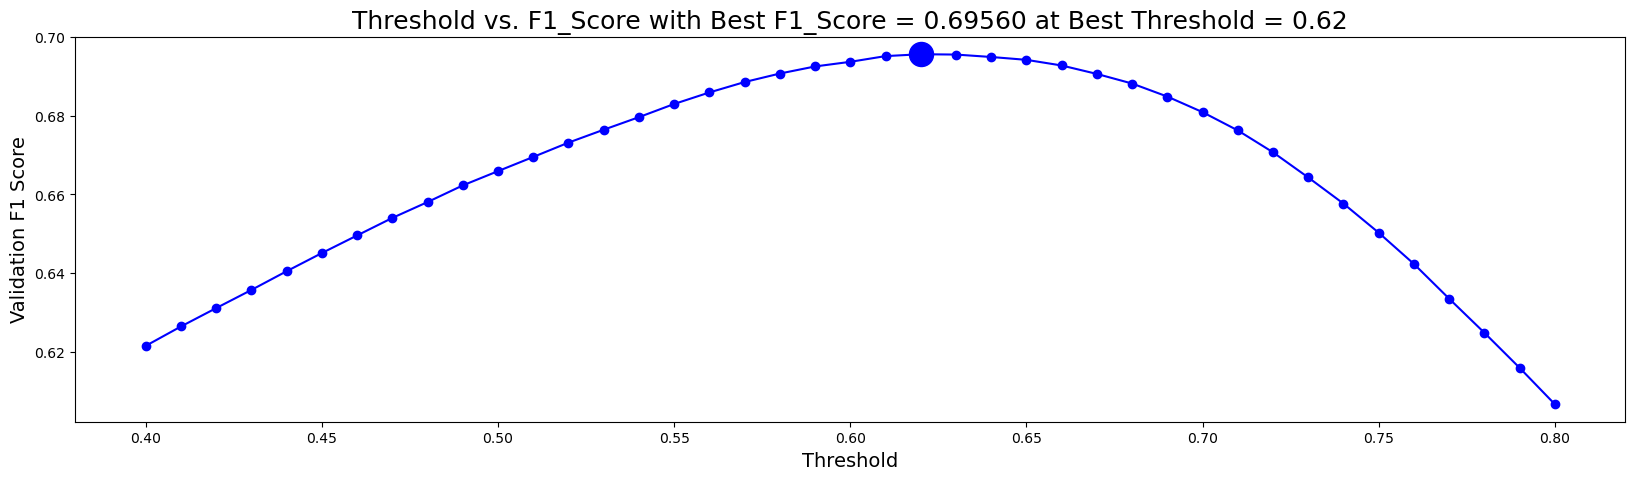

In [36]:
print('Ensambe lgb xgb catboost 1 3 6')
oof = oof_lgb*0.1 +  oof_xgb*0.3 + oof_cbt*0.6
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 2 5 3
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

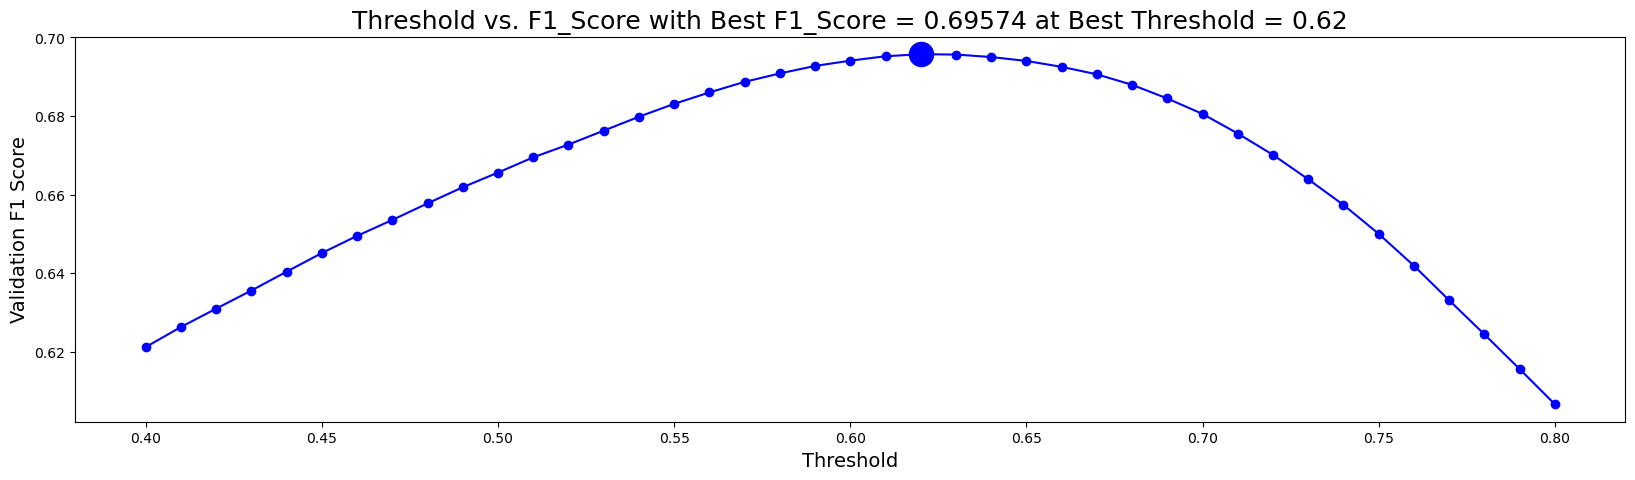

In [37]:
print('Ensambe lgb xgb catboost 2 5 3')
oof = oof_lgb*0.2 +  oof_xgb*0.5 + oof_cbt*0.3
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 2 2 6
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

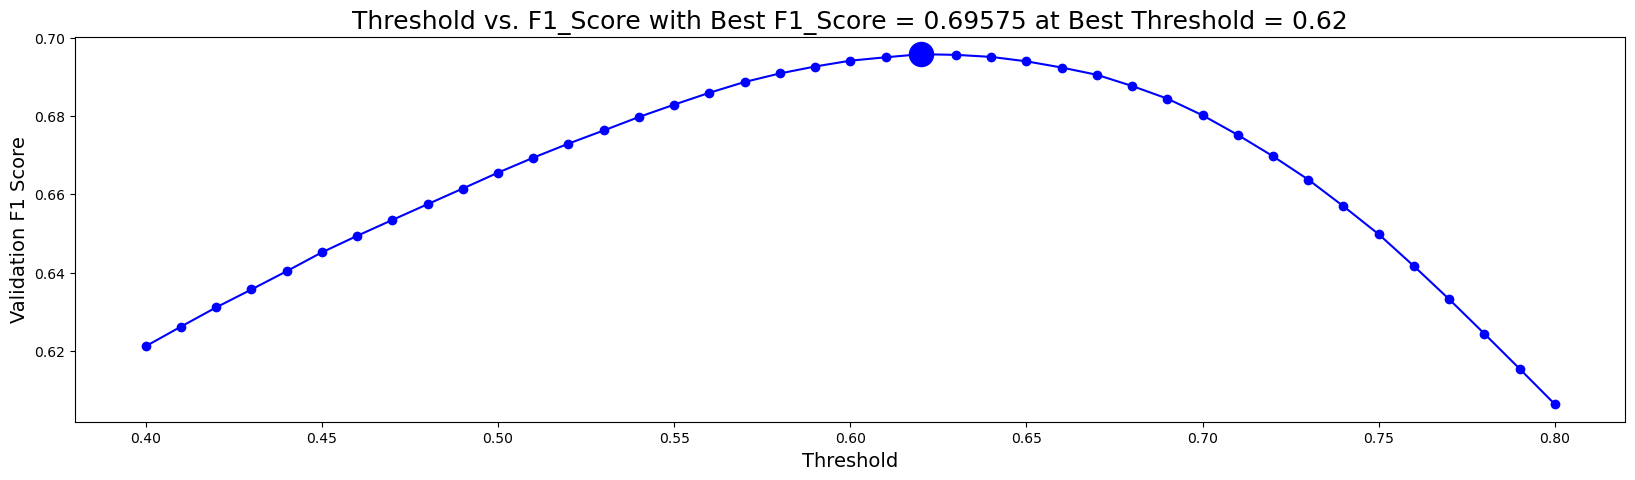

In [38]:
print('Ensambe lgb xgb catboost 2 2 6')
oof = oof_lgb*0.2 +  oof_xgb*0.6 + oof_cbt*0.2
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 1 2 7
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

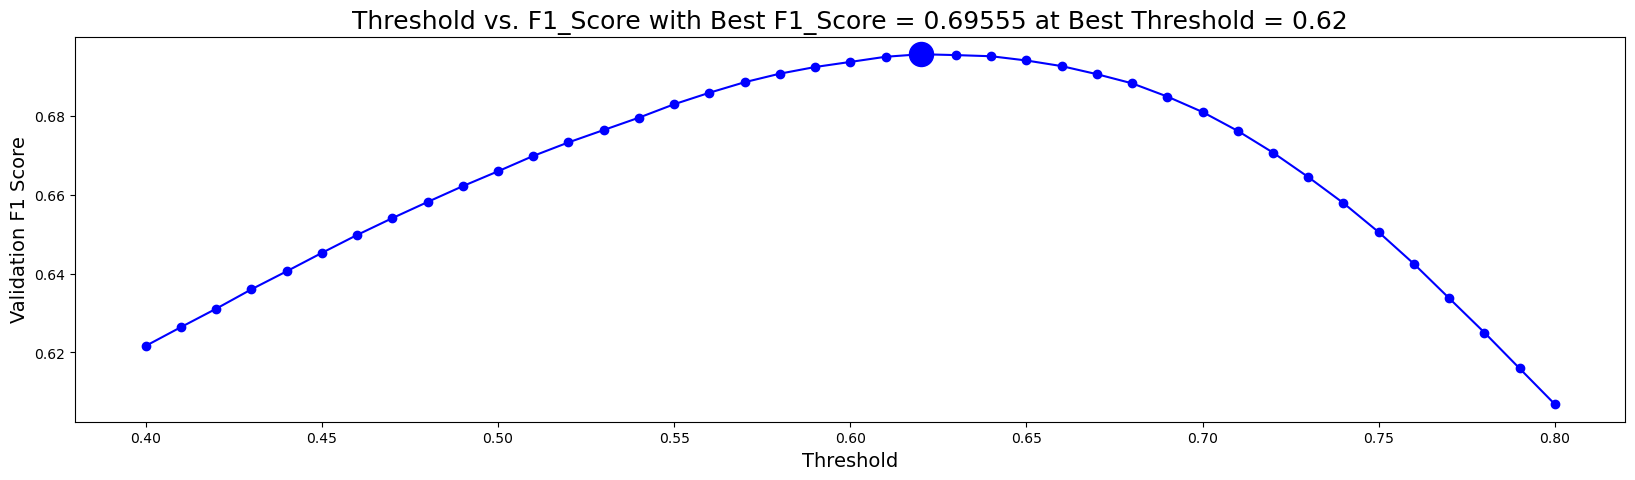

In [39]:
print('Ensambe lgb xgb catboost 1 2 7')
oof = oof_lgb*0.1 +  oof_xgb*0.2 + oof_cbt*0.7
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 1 7 2
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

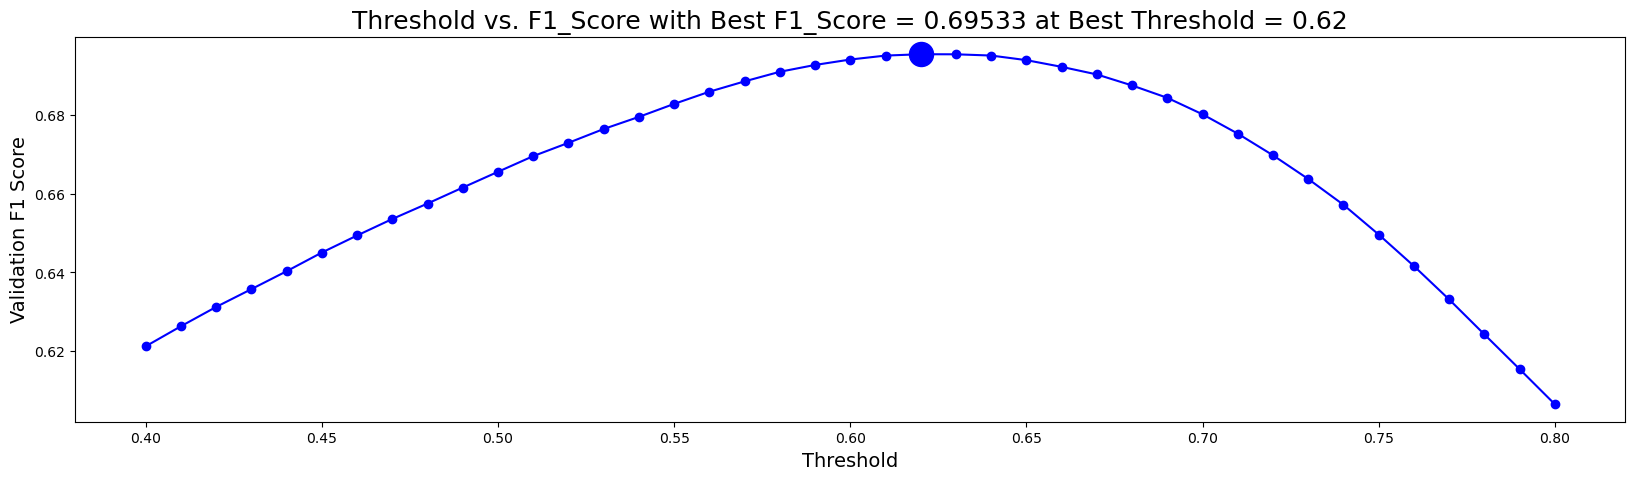

In [40]:
print('Ensambe lgb xgb catboost 1 7 2')
oof = oof_lgb*0.1 +  oof_xgb*0.7 + oof_cbt*0.2
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

Ensambe lgb xgb catboost 1 4 5
0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

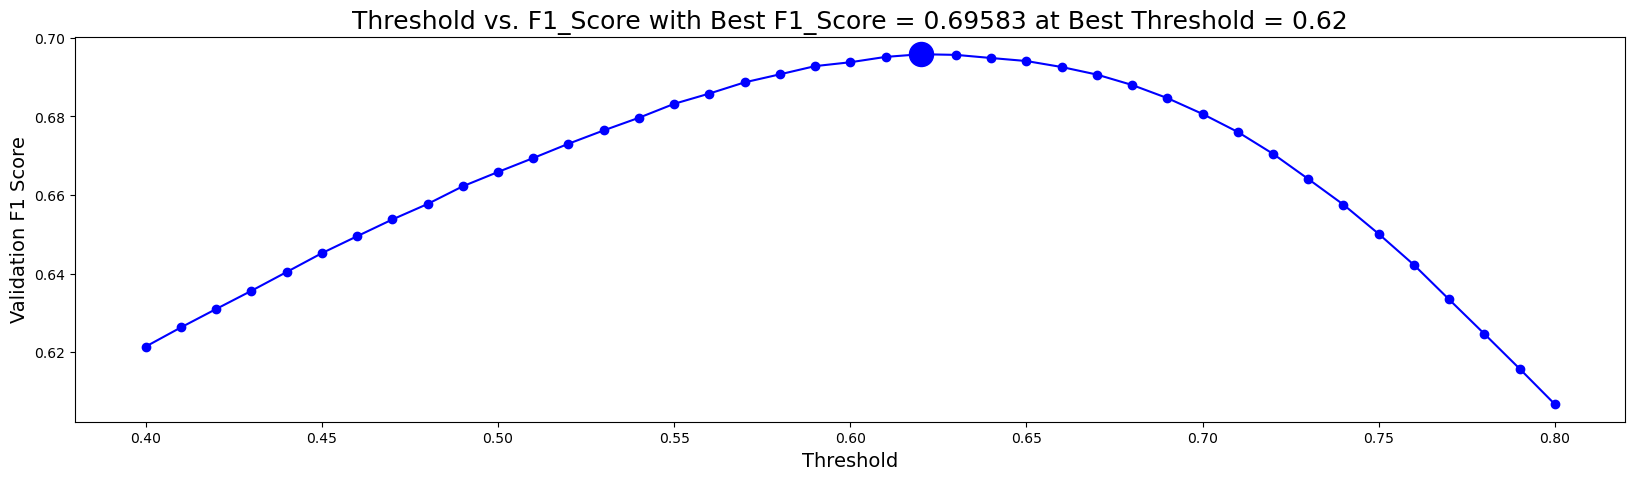

In [41]:
print('Ensambe lgb xgb catboost 1 4 5')
oof = oof_lgb*0.1 +  oof_xgb*0.4 + oof_cbt*0.5
true = oof.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()
# 0.69512

In [42]:
print('FEATURES1 = ',FEATURES1,'\n')

print('FEATURES2 = ',FEATURES2,'\n')

print('FEATURES3 = ',FEATURES3,'\n')
print('TSHRESHOLD = %2.2f'% best_threshold_xgb)

FEATURES1 =  ['event_name_name_unique', 'event_name_fqid_unique', 'event_name_room_fqid_unique', 'name_fqid_unique', 'name_room_fqid_unique', 'fqid_room_fqid_unique', 'event_name_name_count', 'gramps_sum', 'wells_sum', 'toentry_sum', 'groupconvo_sum', 'tomap_sum', 'tostacks_sum', 'tobasement_sum', 'boss_sum', 'cs_sum', 'teddy_sum', 'tunic.historicalsociety_sum', 'plaque_sum', 'directory_sum', 'tunic_sum', 'tunic.kohlcenter_sum', 'plaque.face.date_sum', 'notebook_sum', 'tunic.hub.slip_sum', 'tocollection_sum', 'tunic.capitol_0_sum', 'photo_sum', 'intro_sum', 'retirement_letter_sum', 'togrampa_sum', 'janitor_sum', 'chap1_finale_sum', 'report_sum', 'outtolunch_sum', 'chap1_finale_c_sum', 'block_0_sum', 'doorblock_sum', 'tocloset_sum', 'block_tomap2_sum', 'block_tocollection_sum', 'block_tomap1_sum', 'tunic.historicalsociety.entry_sum', 'tunic.historicalsociety.stacks_sum', 'tunic.historicalsociety.basement_sum', 'tunic.kohlcenter.halloffame_sum', 'tunic.historicalsociety.collection_sum', 